In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns

In [48]:
import add_stat_annotations
import scipy.stats as stats

ModuleNotFoundError: No module named 'add_stat_annotations'

In [2]:
sc.settings.verbosity = 3             # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.logging.print_header()
sc.settings.set_figure_params(dpi=80, facecolor='white')

scanpy==1.8.1 anndata==0.7.6 umap==0.5.1 numpy==1.19.2 scipy==1.5.2 pandas==1.3.4 scikit-learn==0.24.2 statsmodels==0.12.2 python-igraph==0.7.1 leidenalg==0.7.0 pynndescent==0.5.4


In [3]:
adata_1 = sc.read_10x_mtx(
    './matrix_r1/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  
adata_2 = sc.read_10x_mtx(
    './matrix_r2/',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)  

... reading from cache file cache/matrix_r1-matrix.h5ad
... reading from cache file cache/matrix_r2-matrix.h5ad


In [4]:
adata= adata_1.concatenate(adata_2, batch_key='rep')

In [5]:
# Read in and message the clonal information
clones = pd.read_csv('./220404_cell_clone_info.csv')
clones[['cellBC_rew', 'rep']] = clones['cellBC'].str.split('-', expand=True)
clones['cellBC_rew'] =  clones['cellBC_rew'].mask(clones['rep'].eq('1'), clones['cellBC_rew']+ '-1-0')
clones['cellBC_rew'] =  clones['cellBC_rew'].mask(clones['rep'].eq('2'), clones['cellBC_rew']+ '-1-1')
clones_info = clones[['cellBC_rew', 'clone']]

In [6]:
# Read in and message the cell cycle genes
cell_cycle_genes = [x.strip() for x in open('../../SCARED/local_src/210806_scanpy/data/diff_genes.txt')]
s_genes = cell_cycle_genes[:43]
g2m_genes = cell_cycle_genes[43:]
cell_cycle_genes = [x for x in cell_cycle_genes if x in adata.var_names]

In [7]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)
#sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)

filtered out 35 cells that have less than 200 genes expressed
filtered out 15105 genes that are detected in less than 3 cells


In [8]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'feature_types' as categorical


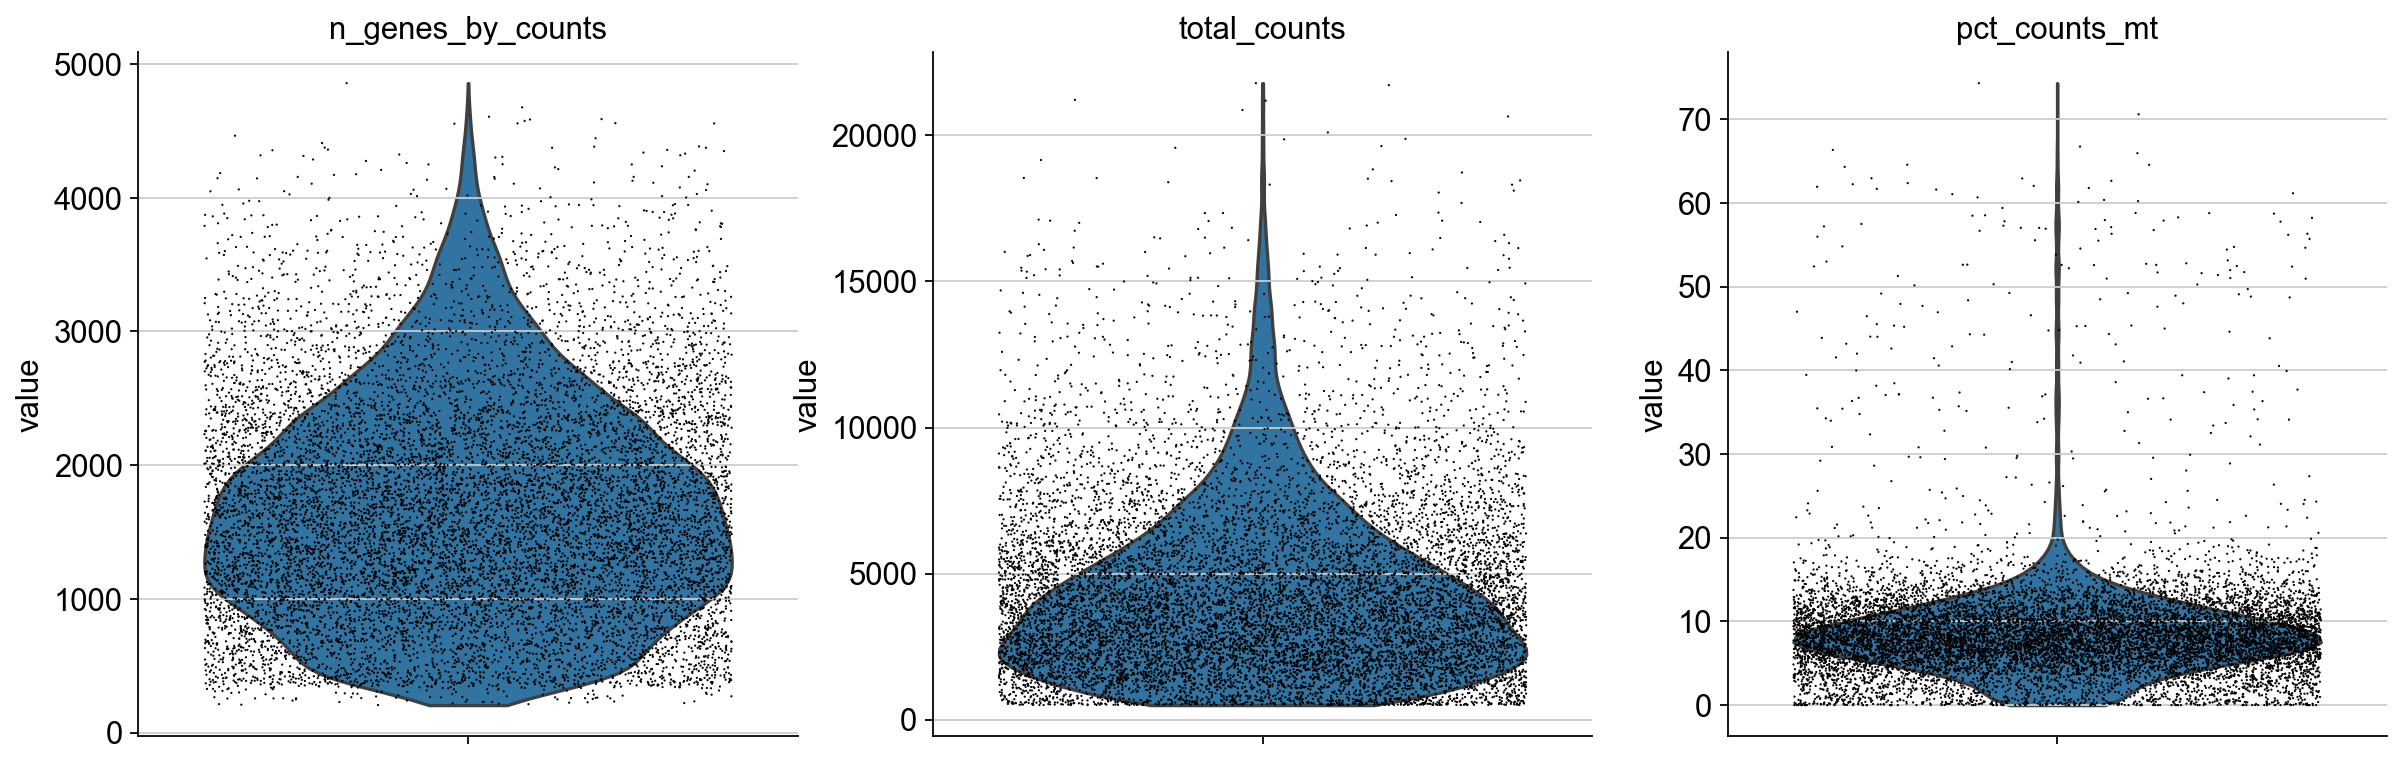

In [9]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [10]:
#adata = adata[adata.obs.total_counts < 60000, :]
adata = adata[adata.obs.pct_counts_mt < 20, :]

In [11]:
sc.pp.log1p(adata)
sc.pp.scale(adata)

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/scanpy/preprocessing/_simple.py:373: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


... as `zero_center=True`, sparse input is densified and may lead to large memory consumption


In [12]:
sc.tl.score_genes_cell_cycle(adata, s_genes=s_genes, g2m_genes=g2m_genes)
adata_cc_genes = adata[:, cell_cycle_genes]
sc.tl.pca(adata_cc_genes)


calculating cell cycle phase
computing score 'S_score'
    finished: added
    'S_score', score of gene set (adata.obs).
    815 total control genes are used. (0:00:01)
computing score 'G2M_score'
    finished: added
    'G2M_score', score of gene set (adata.obs).
    816 total control genes are used. (0:00:01)
-->     'phase', cell cycle phase (adata.obs)
computing PCA
    with n_comps=50
    finished (0:00:00)


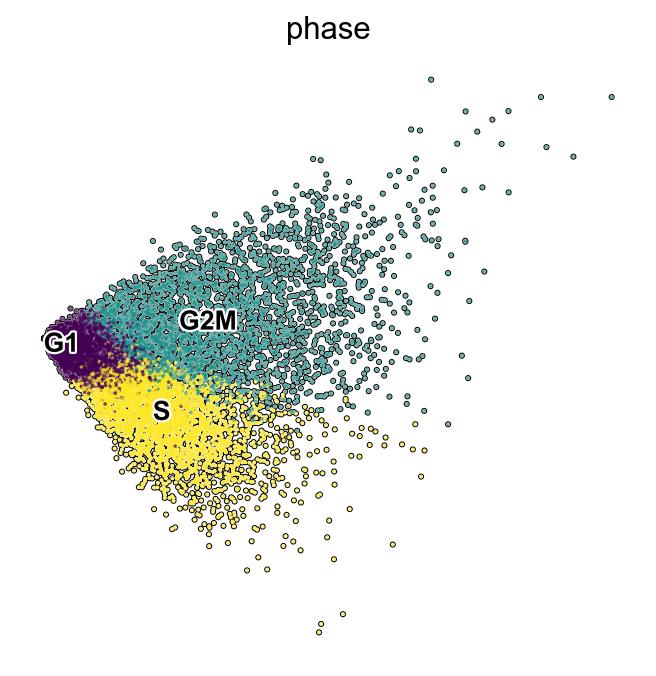

In [53]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.pca_scatter(adata_cc_genes, color='phase',add_outline=True,
    legend_loc = 'on data',legend_fontsize=12, legend_fontoutline=2,frameon=False,
    palette='viridis',show=False)
    plt.savefig('220409_scTRIP_phase.pdf', dpi = 300)


In [14]:
# Add clonal information to the 
clones_info = clones_info.rename(columns={'cellBC_rew': 'cellBC'})
cell_list = adata.obs.index.tolist()
cell_list = pd.DataFrame(cell_list, columns=['cellBC'])
ordered_label = pd.merge(cell_list, clones_info, on='cellBC', how = 'left')
labels = ordered_label.clone.to_list()
adata.obs['clones'] = labels
adata_cc_genes.obs['clones'] = labels

In [15]:
clones = clones_info['clone'].unique().tolist()
for clone in clones:
    if clone != 'nan':
        print(clone)
        adata_cc_genes.obs[clone] = adata_cc_genes.obs['clones'].eq(clone)
        adata_cc_genes.obs[clone] = np.where(adata_cc_genes.obs[clone] == True, clone, 'nan')

clone25
clone14
clone106
clone66
clone47
clone138
clone20
clone6
clone140
clone86
clone80
clone29
clone30
clone10
clone191
clone91
clone122
clone179
clone0
clone2
clone182
clone92
clone76
clone97
clone113
clone53
clone3
clone36
clone73
clone18
clone40
clone5
clone164
clone21
clone15
clone166
clone174
clone4
clone35
clone32
clone101
clone50
clone141
clone150
clone142
clone27
clone116
clone170
clone89
clone67
clone8
clone120
clone24
clone28
clone72
clone9
clone11
clone180
clone177
clone19
clone130
clone82
clone81
clone56
clone125
clone1
clone147
clone114
clone93
clone54
clone65
clone152
clone39
clone158
clone188
clone63
clone109
clone16
clone12
clone45
clone87
clone115
clone7
clone135
clone78
clone70
clone110
clone176
clone84
clone103
clone57
clone77
clone96
clone189
clone71
clone153
clone98
clone102
clone31
clone190
clone161
clone59
clone185
clone157
clone41
clone129
clone74
clone145
clone136
clone107
clone104
clone64
clone187
clone173
clone183
clone123
clone160
clone69
clone42
clone169

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  """


clone85
clone156
clone151
clone51
clone171
clone168
clone112
clone184
clone128
clone61
clone90
clone146
clone75
clone181
clone155
clone132
clone175
clone62
clone37


In [16]:
clones.extend(['phase'])

In [17]:
#sc.pl.pca_scatter(adata_cc_genes, color = clones, palette='Set1', frameon=False, show=False)

In [18]:
sc.tl.embedding_density(adata_cc_genes, basis='pca', groupby='clone12')

/Users/siqizhao/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'clones' as categorical
/Users/siqizhao/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'clone25' as categorical
/Users/siqizhao/miniconda3/lib/python3.7/site-packages/anndata/_core/anndata.py:1220: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reorde

computing density on 'pca'
--> added
    'pca_density_clone12', densities (adata.obs)
    'pca_density_clone12_params', parameter (adata.uns)


/Users/siqizhao/miniconda3/lib/python3.7/site-packages/scanpy/tools/_embedding_density.py:170: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[density_covariate] = density_values


/Users/siqizhao/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_tools/__init__.py:1476: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[density_col_name] = dens_values


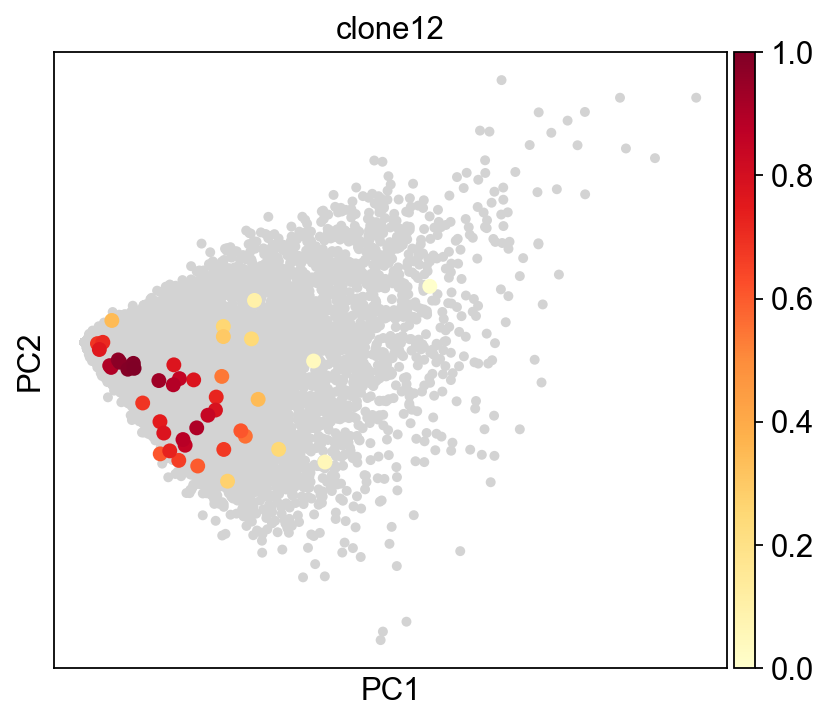

In [58]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.pl.embedding_density(adata_cc_genes, basis='pca', key='pca_density_clone12', group = 'clone12', show = False)
    plt.savefig('220409_scTRIP_phase_clone12.pdf', dpi = 300)


computing density on 'pca'
--> added
    'pca_density_clone1', densities (adata.obs)
    'pca_density_clone1_params', parameter (adata.uns)


/Users/siqizhao/miniconda3/lib/python3.7/site-packages/scanpy/plotting/_tools/__init__.py:1476: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  adata.obs[density_col_name] = dens_values


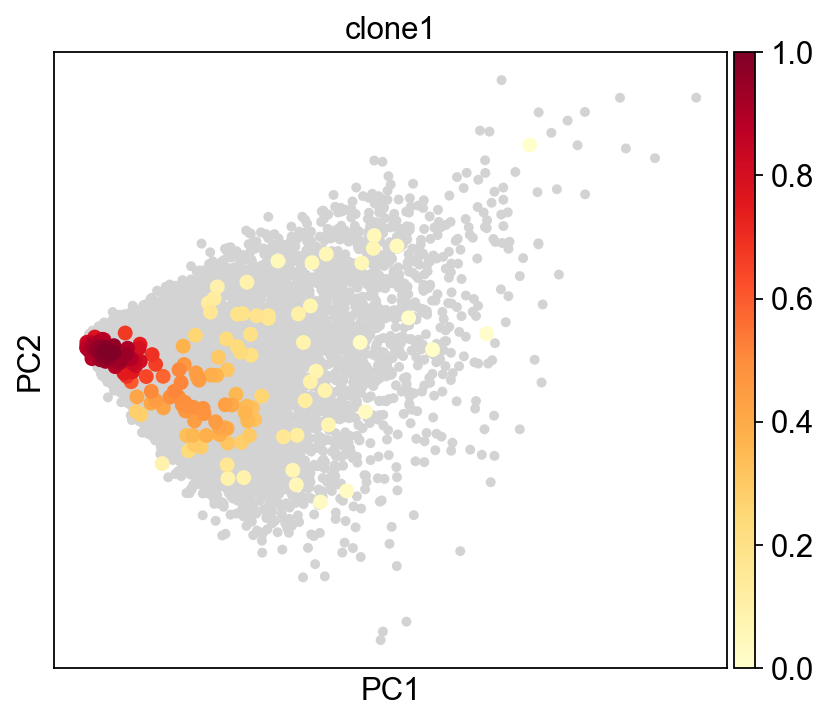

In [57]:
with rc_context({'figure.figsize': (5, 5)}):
    fig = sc.tl.embedding_density(adata_cc_genes, basis='pca', groupby='clone1')
    fig = sc.pl.embedding_density(adata_cc_genes, basis='pca', key='pca_density_clone1', group = 'clone1', show = False)
    plt.savefig('220409_scTRIP_phase_clone1.pdf', dpi = 300)

In [21]:
trip_clones = pd.read_csv('./20220404_trip_clones.tsv', sep= '\t')

In [22]:
np.mean(trip_clones['clone'].value_counts())

2.3802083333333335

In [23]:
# Get the number of cells per clonece
cell_clones = adata_cc_genes.obs.clones
cell_clones = cell_clones.to_frame(name = 'clone')
v_counts = cell_clones.clone.value_counts()
cell_clones_usable = cell_clones[cell_clones.clone.isin(v_counts.index[v_counts.gt(5)])]


In [24]:
cell_phase = adata_cc_genes.obs.phase
cell_phase = cell_phase.to_frame(name = 'phase')

In [25]:
cell_clones_usable.reset_index(inplace=True)
cell_clones_usable = cell_clones_usable.rename(columns={'index': 'cellBC'})
cell_phase.reset_index(inplace=True)
cell_phase = cell_phase.rename(columns={'index': 'cellBC'})
cell_info = pd.merge(cell_clones_usable, cell_phase, on = 'cellBC', how = 'inner')

In [26]:
cell_info

,cellBC,clone,phase
0,AAACCCAAGACGCATG-1-0,clone138,G2M
1,AAACCCAAGAGTACCG-1-0,clone10,G1
2,AAACCCATCGCTCCTA-1-0,clone30,G1
3,AAACGAACAGCGTGAA-1-0,clone16,S
4,AAACGAAGTGGCATCC-1-0,clone102,S
...,...,...,...
9236,TTTGGTTTCCGGTTCT-1-1,clone36,S
9237,TTTGGTTTCTTGATTC-1-1,clone20,S
9238,TTTGTTGAGACTCCGC-1-1,clone0,G1
9239,TTTGTTGGTCTCCCTA-1-1,clone180,G1


### Scoring Clones with Cell Cycle
- According to Nirendra's paper, I think that G1 vs G2/S/M seem to be really important

In [27]:
clone_percentage = []
clone_list = cell_info.clone.unique().tolist()
for clone in clone_list:
    if clone != 'nan':
        data_slice = cell_info[cell_info.clone == clone]
        g1_phase = data_slice.phase[data_slice.phase == 'G1'].count()/data_slice.phase.count()
        g2_phase = data_slice.phase[data_slice.phase == 'G2M'].count()/data_slice.phase.count()
        s_phase = data_slice.phase[data_slice.phase == 'S'].count()/data_slice.phase.count()
        clone_percentage.append([clone, g1_phase, g2_phase, s_phase])

clone_cell_cycle = pd.DataFrame(clone_percentage, columns = ['clone', 'G1', 'G2M', 'S'])
        

(0.0, 0.6)

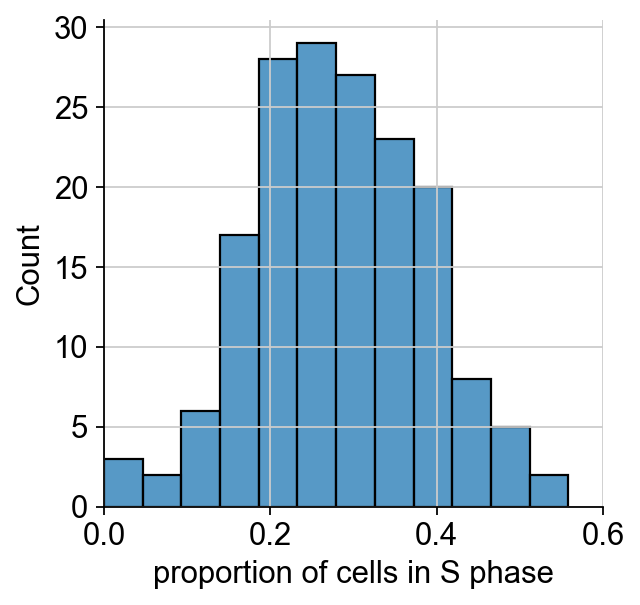

In [28]:
sns.histplot(clone_cell_cycle['S'], bins = 'auto')
plt.xlabel('proportion of cells in S phase')
sns.despine()
plt.xlim(0,0.6)
#plt.savefig('220406_proportion_of_cells_in_S_phase.pdf', dpi = 300)

Text(0.5, 0, 'Percentage of cells in G2/S/M phase')

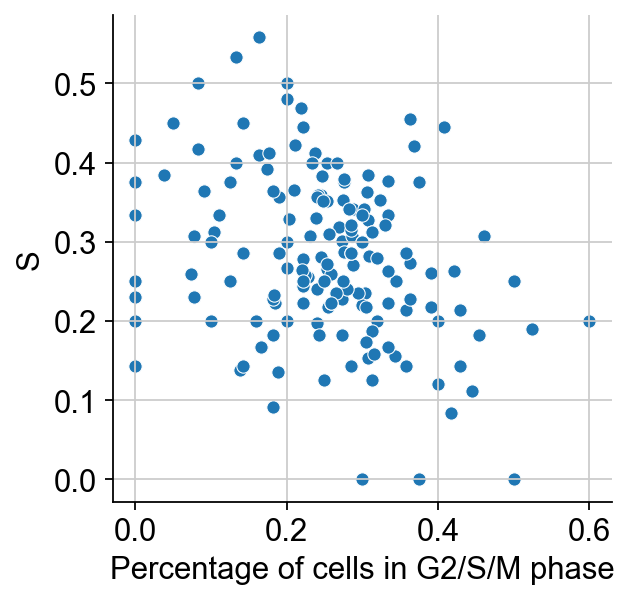

In [29]:
sns.scatterplot(x = 'G2M', y = 'S', data = clone_cell_cycle)
sns.despine()
plt.xlabel('Percentage of cells in G2/S/M phase')
#plt.xlim(0,1)

In [30]:
# Now we look at the average mean expression level for different genomic locations 
bc_info = pd.read_csv('./all_CAS_pools_combined.tsv', sep = '\t')
bc_info = bc_info.loc[bc_info.id.str.contains('_LP1_latest')]

In [31]:
bc_info.annotation.to_list()

['13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '12_Repressed',
 '11_Weak_Txn',
 '11_Weak_Txn',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '10_Txn_Elongation',
 '13_Heterochrom/lo',
 '10_Txn_Elongation',
 '11_Weak_Txn',
 '4_Strong_Enhancer',
 '13_Heterochrom/lo',
 '10_Txn_Elongation',
 '11_Weak_Txn',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '7_Weak_Enhancer',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '11_Weak_Txn',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',
 '4_Strong_Enhancer',
 '13_Heterochrom/lo',
 '10_Txn_Elongation',
 '13_Heterochrom/lo',
 '11_Weak_Txn',
 '13_Heterochrom/lo',
 '12_Repressed',
 '11_Weak_Txn',
 '14_Repetitive/CNV',
 '10_Txn_Elongation',
 '6_Weak_Enhancer',
 '13_Heterochrom/lo',
 '13_Heterochrom/lo',


In [32]:
# Now read in the tBC barcodes with different tripBCs
tbc_info = pd.read_csv('./20220404_trip_clones.tsv', sep = '\t')
tbc_info = tbc_info.loc[tbc_info.clone.isin(clone_list)]

In [33]:
bc_info_master = pd.merge(bc_info, tbc_info, on = 'tBC', how = 'inner')

In [34]:
bc_info_master = pd.merge(bc_info_master, clone_cell_cycle, on = 'clone', how = 'inner')

In [35]:
bc_info_master.columns

Index(['tBC', 'mean', 'median', 'var', 'auc', 'mu', 'alpha', 'ncells', 'sum',
       'ncells_log10', 'MIN', 'twopower_MIN', 'fano', 'cv2', 'pool', 'mean_z',
       'var_z', 'fano_z', 'cv2_z', 'chr', 'location', 'strand', 'annotation',
       'id', 'clone', 'G1', 'G2M', 'S'],
      dtype='object')

In [36]:
bc_info_master['active_state'] = bc_info_master['G2M'] + bc_info_master['S']

In [37]:
relavent_list = []
for clone in clone_list:
    if clone != 'nan':
        data_slice = bc_info_master[bc_info_master.clone == clone]
        mean = data_slice['mean_z'].mean()
        MIN = data_slice.MIN.mean()
        g1 = data_slice.G1.mean()
        g2 = data_slice.G2M.mean()
        s = data_slice.S.mean()
        active_state = data_slice.active_state.mean()
        if s < 0.3:
            label = 'low'
        elif s >0.32:
            label = 'high'
        else:
            label = 'medium'
        relavent_list.append([clone, mean, MIN, g1, g2, s, label, active_state])
clone_info_master = pd.DataFrame(relavent_list, columns = ['clone', 'mean_z', 'MIN', 'G1', 'G2M', 'S', 'label', 'active_state'])

In [38]:
clone_info_master.head()

,clone,mean_z,MIN,G1,G2M,S,label,active_state
0,clone138,-1.284098,0.128813,0.592593,0.185185,0.222222,low,0.407407
1,clone10,0.809809,0.019730,0.481928,0.253012,0.265060,low,0.518072
2,clone30,1.711807,-0.095024,0.371287,0.287129,0.341584,high,0.628713
3,clone16,0.216573,0.592711,0.426573,0.272727,0.300699,medium,0.573427
4,clone102,0.035427,-0.520827,0.576923,0.038462,0.384615,high,0.423077


<AxesSubplot:xlabel='active_state', ylabel='Count'>

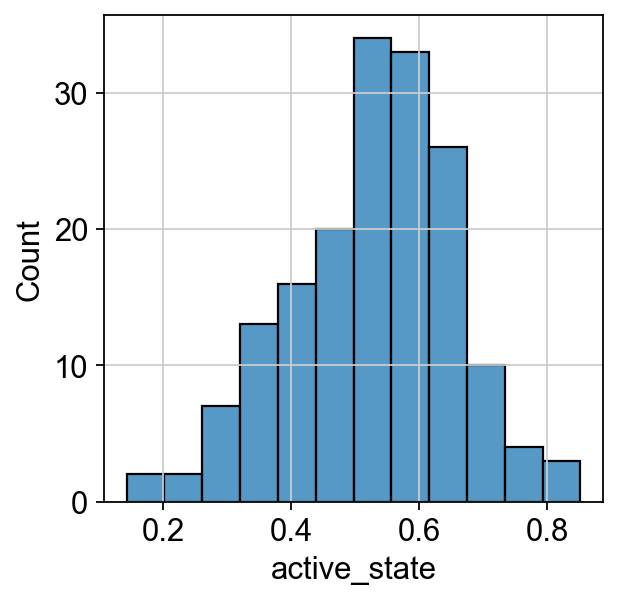

In [39]:
sns.histplot(x = 'active_state', data =clone_info_master)

In [40]:
import add_stat_annotation 
ax = sns.violinplot(x = 'label', y = 'mean_z', order = ['low', 'medium', 'high'], data = clone_info_master, color = 'lightgrey')
add_stat_annotation(ax, data = clone_info_master, x = 'label', y = 'mean_z', order = ['low', 'medium', 'high'], box_pairs = [('low', 'medium'), ('low', 'high'), ('medium', 'high')], test = 't-test_ind', text_format = 'star', loc = 'outside', verbose = 2)

ModuleNotFoundError: No module named 'add_stat_annotation'

NameError: name 'add_stat_annotation' is not defined

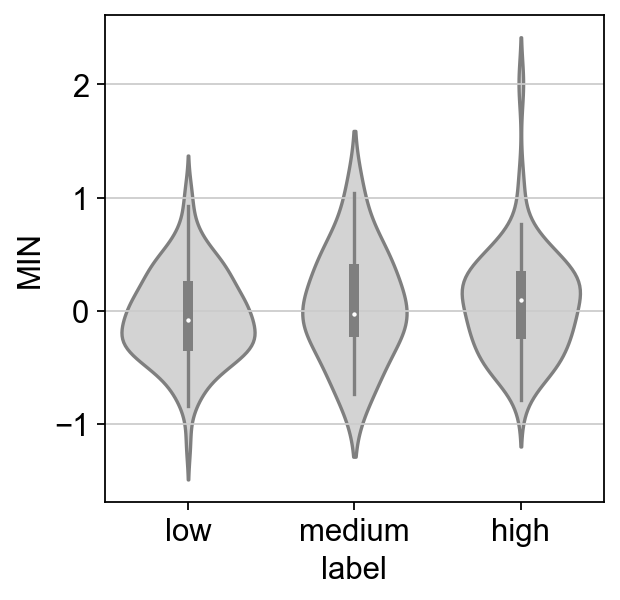

In [41]:
ax = sns.violinplot(x = 'label', y = 'MIN', order = ['low', 'medium', 'high'], data = clone_info_master, color = 'lightgrey')
add_stat_annotation(ax, data = clone_info_master, x = 'label', y = 'MIN', order = ['low', 'medium', 'high'], box_pairs = [('low', 'medium'), ('low', 'high'), ('medium', 'high')], test = 't-test_ind', text_format = 'star', loc = 'outside', verbose = 2)

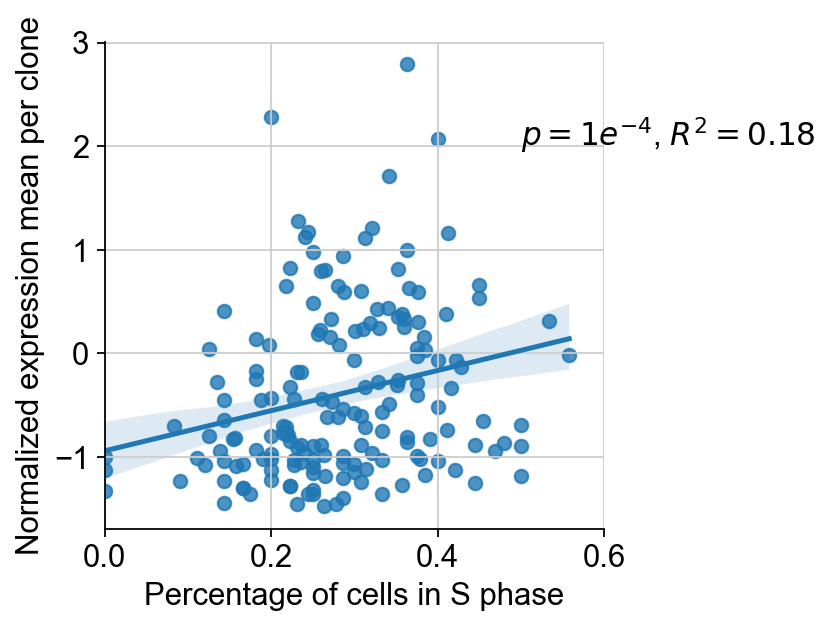

In [42]:
sns.regplot(y = 'mean_z', x = 'S', data = clone_info_master)
plt.xlim(0,0.6)
plt.xlabel('Percentage of cells in S phase')
plt.ylabel('Normalized expression mean per clone')
plt.text(0.5,2, r'$p = 1e^{-4}$, $R^2 = 0.18$')
sns.despine()
#plt.tight_layout()
plt.savefig('220406_mean_expression_vs_S_phase.pdf', dpi = 300)

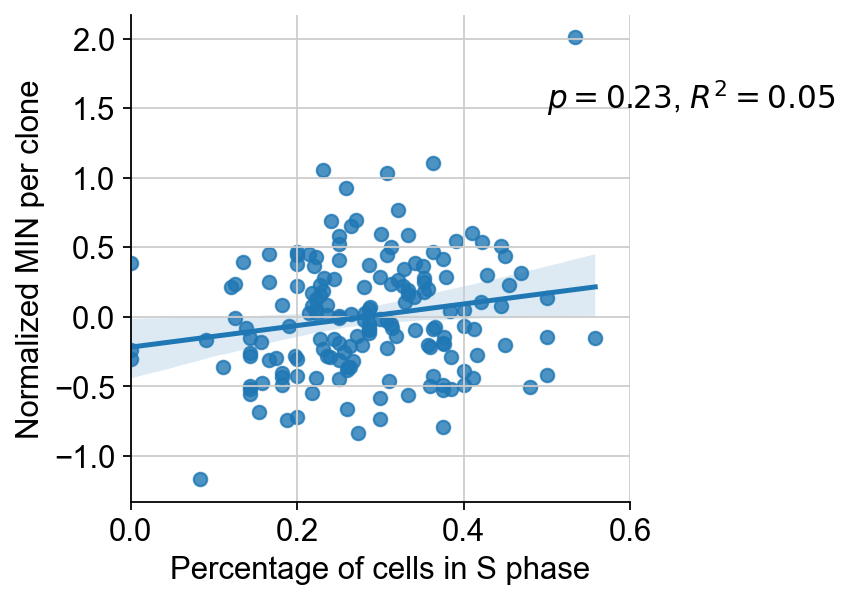

In [52]:
sns.regplot(y = 'MIN', x = 'S', data = clone_info_master)
plt.xlim(0,0.6)
plt.xlabel('Percentage of cells in S phase')
plt.ylabel('Normalized MIN per clone')
plt.text(0.5,1.5, r'$p = 0.23$, $R^2 = 0.05$')
sns.despine()
#plt.tight_layout()
plt.savefig('220406_MIN_expression_vs_S_phase.pdf', dpi = 300)

In [50]:
slope, intercept, r_value, p_value, std_err = stats.linregress(bc_info_master['mean_z'], bc_info_master['S'])
print(f'the rvalue is {r_value}, and the pvalue is {p_value}')

the rvalue is 0.18165559003128076, and the pvalue is 0.00013920984704723775


In [51]:
slope, intercept, r_value, p_value, std_err = stats.linregress(bc_info_master['MIN'], bc_info_master['S'])
print(f'the rvalue is {r_value}, and the pvalue is {p_value}')

the rvalue is 0.05673569298087747, and the pvalue is 0.23765706690997568


In [49]:
import scipy.stats as stats